# HSCT survival: neural network models datasets test

## 1. Notebook set-up

### 1.1. Imports & options

In [ ]:
# Standard library imports
import os
import logging
import pickle
from itertools import product

# Set logging levels for TensorFlow before importing
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

# PyPI imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.config import threading
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping

# Internal imports
import configuration as config
import functions.helper as helper_funcs

# Other notebook environment
os.environ['CUDA_VISIBLE_DEVICES']='1'
os.environ['OMP_NUM_THREADS'] = '2'
threading.set_intra_op_parallelism_threads(2)
threading.set_inter_op_parallelism_threads(2)
pd.set_option('display.max_rows', 500)

notebook_num='01.4'

### 1.2. Parameters

In [2]:
# Run options
optimize_classifier_architecture=False
evaluate_datasets=False

training_epochs=500
learning_rate=0.0005

### 1.3. Files

In [3]:
# Dataset definition file
datasets_file=f'{config.PROCESSED_DATA}/02.1-dataset_definitions.pkl'

# Read the dataset metadata
with open(datasets_file, 'rb') as input_file:
    datasets=pickle.load(input_file)

print(f'Datasets: {datasets.keys()}')

# Dataset testing results
regression_test_results_file=f'{config.RESULTS}/{notebook_num}-regression_test_results.pkl'
regression_test_performance_plots=f'{config.PLOTS}/{notebook_num}-regression_test_performance.jpg'
regression_test_residuals_plots=f'{config.PLOTS}/{notebook_num}-regression_test_residuals.jpg'
classification_architecture_optimization_results_file=f'{config.RESULTS}/{notebook_num}-classification_architecture_optimization_results.pkl'
classification_architecture_optimization_training_curves_file=f'{config.PLOTS}/{notebook_num}-classification_architecture_optimization_training_curves.jpg'
classification_dataset_evaluation_results_file=f'{config.RESULTS}/{notebook_num}-classification_dataset_evaluation_results.pkl'
classification_dataset_evaluation_training_curves_file=f'{config.PLOTS}/{notebook_num}-classification_dataset_evaluation_training_curves.jpg'
classification_test_performance_plots=f'{config.PLOTS}/{notebook_num}-classification_test_performance.jpg'
classification_test_probability_plots=f'{config.PLOTS}/{notebook_num}-classification_test_probability.jpg'

Datasets: dict_keys(['Nominal one-hot/ordinal encoded, NANs encoded', 'Nominal one-hot/ordinal encoded, NANs imputed', 'All ordinal encoded, NAN encoded', 'All ordinal encoded, NAN imputed', 'Binary target encoded', 'Continuous target encoded'])


## 2. Classification model

### 2.1. Architecture optimization

#### 2.1.1. Hyperparameter search space

In [4]:
# Define hyperparameter search space for architecture optimization
input_units_list=[64,128]
max_units_list=[64,128,256,512]
waist_layers_list=[1,2,3]
step_down_list=[2,4]
output_units_list=[2]

hyperparameter_sets=list(
    product(
        input_units_list,
        max_units_list,
        waist_layers_list,
        step_down_list,
        output_units_list
    )
)

#### 2.1.1. Training run

In [5]:
%%time

if optimize_classifier_architecture == True:

    architecture_optimization_results={}

    # Load one of the datasets
    with open(datasets['Nominal one-hot/ordinal encoded, NANs imputed'], 'rb') as input_file:
        data_dict=pickle.load(input_file)

    # Extract and prep. training and validation
    training_labels_df=data_dict['Training labels']
    training_features_df=data_dict['Training features']

    validation_labels_df=data_dict['Testing labels']
    validation_features_df=data_dict['Testing features']

    training_labels_df['efs_time']=np.log(training_labels_df['efs_time'])
    validation_labels_df['efs_time']=np.log(validation_labels_df['efs_time'])

    # Set the weight initializer function
    initializer=GlorotUniform(seed=315)

    # Set-up the L1L2 for the dense layers
    regularizer=L1L2(l1=0.001, l2=0.0001)

    for hyperparameters in hyperparameter_sets:
        input_units=hyperparameters[0]
        max_units=hyperparameters[1]
        waist_layers=hyperparameters[2]
        step_down=hyperparameters[3]
        output_units=hyperparameters[4]

        print(f' Input units: {input_units}, max units: {max_units}, waist layers {waist_layers}, step_down: {step_down} output units: {output_units}')

        model_layers=[Input(shape=training_features_df.shape[1])]
        units=input_units

        while units < max_units:
            model_layers.append(
                Dense(units, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer)
            )

            units*=2

        for _ in range(waist_layers - 1):
            model_layers.append(
                Dense(max_units, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer)
            )

        while units >= output_units:
            model_layers.append(
                Dense(units, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer)
            )

            units/=step_down

        model_layers.append(
            Dense(1, activation='sigmoid', kernel_initializer=initializer)
        )

        classification_model=Sequential(model_layers)

        # Set early stopping on validation binary cross-entropy
        early_stopping_callback=EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10)

        classification_model.compile(
            loss='binary_crossentropy',
            optimizer=Adam(learning_rate=learning_rate),
            metrics=[Precision(name='precision'), Recall(name='recall')]
        )

        # Calculate class weighting
        pos_examples=sum(training_labels_df['efs'])
        neg_examples=len(training_labels_df['efs']) - pos_examples
        neg_class_weight=(1 / neg_examples) * (len(training_labels_df['efs']) / 2.0)
        pos_class_weight=(1 / pos_examples) * (len(training_labels_df['efs']) / 2.0)

        # Do the training run
        architecture_optimization_result=classification_model.fit(
            training_features_df,
            training_labels_df['efs'],
            batch_size=512,
            validation_data=[validation_features_df, validation_labels_df['efs']],
            epochs=training_epochs,
            verbose=False,
            class_weight={0: neg_class_weight, 1: pos_class_weight},
            callbacks=[early_stopping_callback]
        )

        architecture_optimization_results[hyperparameters]=architecture_optimization_result

    with open(classification_architecture_optimization_results_file, 'wb') as output_file:
        pickle.dump(architecture_optimization_results, output_file)

else:

    # Load last result
    with open(classification_architecture_optimization_results_file, 'rb') as input_file:
        architecture_optimization_results=pickle.load(input_file)

print()


CPU times: user 9.09 s, sys: 831 ms, total: 9.92 s
Wall time: 10.4 s


#### 2.1.3. Results

##### 2.1.4.1. Precision & recall

In [6]:
architecture_optimization_scores={
    'Recall RMSE':[],
    'Precision RMSE':[],
    'Mean recall':[],
    'Mean precision':[],
    'F1 score':[],
    'Hyperparameters':[]
}

for hyperparameters in hyperparameter_sets:

    architecture_optimization_results[hyperparameters].history['recall']

    recall_RMSE=helper_funcs.root_mean_squared_error(
        architecture_optimization_results[hyperparameters].history['recall'],
        architecture_optimization_results[hyperparameters].history['val_recall']
    )

    precision_RMSE=helper_funcs.root_mean_squared_error(
        architecture_optimization_results[hyperparameters].history['precision'],
        architecture_optimization_results[hyperparameters].history['val_precision']
    )

    mean_recall=np.mean(architecture_optimization_results[hyperparameters].history['val_recall'][-10:])
    mean_precision=np.mean(architecture_optimization_results[hyperparameters].history['val_precision'][-10:])
    f_score=2*((mean_precision*mean_recall) / (mean_precision+mean_recall))

    architecture_optimization_scores['Recall RMSE'].append(recall_RMSE)
    architecture_optimization_scores['Precision RMSE'].append(precision_RMSE)
    architecture_optimization_scores['Mean recall'].append(mean_recall)
    architecture_optimization_scores['Mean precision'].append(mean_precision)
    architecture_optimization_scores['F1 score'].append(f_score)
    architecture_optimization_scores['Hyperparameters'].append(hyperparameters)

architecture_optimization_scores_df=pd.DataFrame.from_dict(architecture_optimization_scores)
architecture_optimization_scores_df.sort_values('F1 score', inplace=True, ascending=False)
architecture_optimization_scores_df.reset_index(drop=True, inplace=True)
architecture_optimization_scores_df.head(len(architecture_optimization_scores_df))

,Recall RMSE,Precision RMSE,Mean recall,Mean precision,F1 score,Hyperparameters
0,0.067981,0.020369,0.741139,0.687260,0.713184,"(64, 64, 3, 4, 2)"
1,0.057314,0.008912,0.752862,0.675569,0.712124,"(64, 128, 2, 2, 2)"
2,0.085587,0.022912,0.734919,0.688616,0.711014,"(128, 256, 1, 4, 2)"
3,0.039579,0.009396,0.735922,0.683582,0.708787,"(64, 128, 3, 4, 2)"
4,0.070503,0.019816,0.729582,0.688373,0.708379,"(64, 256, 1, 4, 2)"
5,0.027762,0.005590,0.726868,0.689703,0.707798,"(128, 512, 1, 4, 2)"
6,0.072404,0.018055,0.724724,0.690993,0.707457,"(128, 64, 1, 4, 2)"
7,0.052521,0.022609,0.727448,0.685964,0.706097,"(64, 64, 2, 2, 2)"
8,0.070111,0.010602,0.724632,0.687817,0.705745,"(128, 64, 2, 2, 2)"
9,0.063930,0.011042,0.720823,0.690660,0.705419,"(64, 64, 1, 2, 2)"


##### 2.1.4.2. Training curves

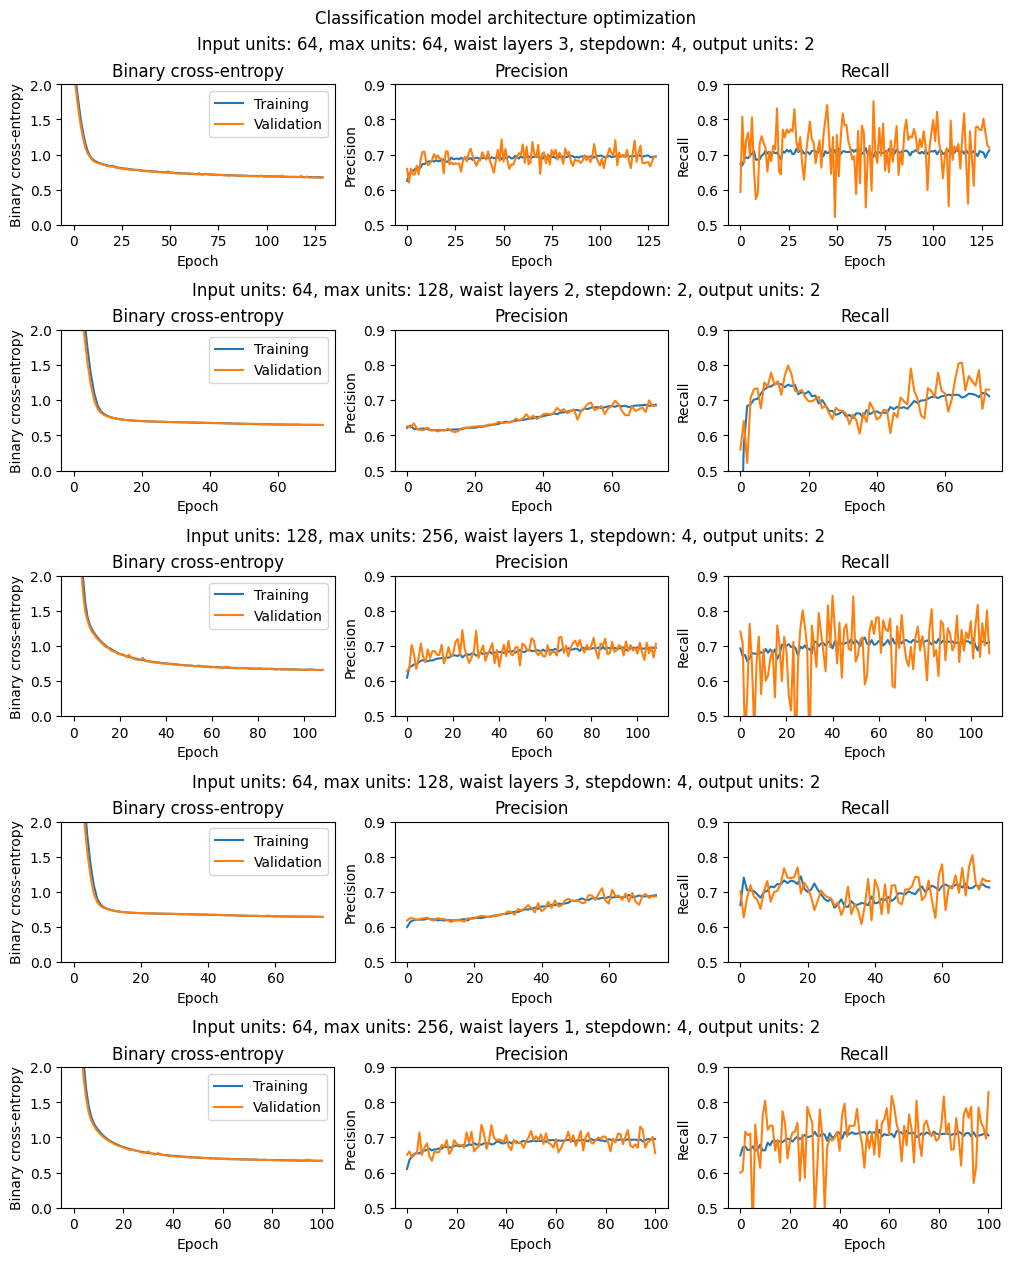

In [7]:
top_hyperparameters=architecture_optimization_scores_df['Hyperparameters'][:5].values
fig=plt.figure(figsize=(10,len(top_hyperparameters)*2.5), constrained_layout=True)
fig.suptitle('Classification model architecture optimization')

subfigs=fig.subfigures(nrows=len(top_hyperparameters), ncols=1)

# Loop on the training results
for subfig, hyperparameters in zip(subfigs, top_hyperparameters):

    # Get the training result for this hyperparameter set
    training_result=architecture_optimization_results[hyperparameters]

    # Row title
    subfig.suptitle(f'Input units: {hyperparameters[0]}, max units: {hyperparameters[1]}, waist layers {hyperparameters[2]}, stepdown: {hyperparameters[3]}, output units: {hyperparameters[4]}')

    axs=subfig.subplots(nrows=1, ncols=3)

    axs[0].set_title('Binary cross-entropy')
    axs[0].plot(training_result.history['loss'], label='Training')
    axs[0].plot(training_result.history['val_loss'], label='Validation')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Binary cross-entropy')
    axs[0].set_ylim(0,2)
    axs[0].legend(loc='upper right')

    axs[1].set_title('Precision')
    axs[1].plot(training_result.history['precision'])
    axs[1].plot(training_result.history['val_precision'])
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Precision')
    axs[1].set_ylim(0.5,0.9)

    axs[2].set_title('Recall')
    axs[2].plot(training_result.history['recall'])
    axs[2].plot(training_result.history['val_recall'])
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Recall')
    axs[2].set_ylim(0.5,0.9)

# Save and show the plot
fig.savefig(classification_architecture_optimization_training_curves_file, dpi=300, bbox_inches='tight')
fig.show()

### 2.2. Dataset evaluation

#### 2.2.1. Hyperparameter choices

In [8]:
input_units=64
max_units=128
waist_layers=2
step_down=2
output_units=2
training_epochs=5000
learning_rate=0.00001

#### 2.2.2. Training run

In [9]:
%%time

if evaluate_datasets == True:

    classification_models={}
    classification_training_results={}

    # Set the weight initializer function
    initializer=GlorotUniform(seed=315)

    # Set-up the L1L2 for the dense layers
    regularizer=L1L2(l1=0.001, l2=0.0001)

    # Loop on the datasets
    for dataset, data_file in datasets.items():
        print(f'{dataset}')

        # Load the data
        with open(data_file, 'rb') as input_file:
            data_dict=pickle.load(input_file)

        training_labels_df=data_dict['Training labels']
        training_features_df=data_dict['Training features']

        classification_models[dataset]=[]
        classification_training_results[dataset]=[]

        model_layers=[Input(shape=training_features_df.shape[1])]
        units=input_units

        while units < max_units:
            model_layers.append(
                Dense(units, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer)
            )

            units*=2

        for _ in range(waist_layers - 1):
            model_layers.append(
                Dense(max_units, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer)
            )

        while units >= output_units:
            model_layers.append(
                Dense(units, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer)
            )

            units/=step_down

        model_layers.append(
            Dense(1, activation='sigmoid', kernel_initializer=initializer)
        )

        classification_model=Sequential(model_layers)

        classification_model.compile(
            loss='binary_crossentropy',
            optimizer=Adam(learning_rate=learning_rate),
            metrics=[Precision(name='precision'), Recall(name='recall')]
        )

        # Calculate class weighting
        pos_examples=sum(training_labels_df['efs'])
        neg_examples=len(training_labels_df['efs']) - pos_examples
        neg_class_weight=(1 / neg_examples) * (len(training_labels_df['efs']) / 2.0)
        pos_class_weight=(1 / pos_examples) * (len(training_labels_df['efs']) / 2.0)

        # Do the training run
        training_results=classification_model.fit(
            training_features_df,
            training_labels_df['efs'],
            batch_size=1028,
            validation_split=0.25,
            epochs=training_epochs,
            verbose=False,
            class_weight={0: neg_class_weight, 1: pos_class_weight}
        )

        classification_training_results[dataset]=training_results
        classification_models[dataset]=classification_model

    classification_results={'Training results': classification_training_results}
    classification_results['Models']=classification_models

    with open(classification_dataset_evaluation_results_file, 'wb') as output_file:
        pickle.dump(classification_results, output_file)

else:

    # Load last result
    with open(classification_dataset_evaluation_results_file, 'rb') as input_file:
        classification_results=pickle.load(input_file)

    classification_training_results=classification_results['Training results']
    classification_models=classification_results['Models']

print()


CPU times: user 1.3 s, sys: 32.1 ms, total: 1.33 s
Wall time: 1.32 s


#### 2.2.3. Results

##### 2.2.3.1. Training curves

In [10]:
dataset_evaluation_scores={
    'Recall RMSE':[],
    'Precision RMSE':[],
    'Mean recall':[],
    'Mean precision':[],
    'F1 score':[],
    'Dataset':[]
}

for dataset, results in classification_training_results.items():

    results.history['recall']

    recall_RMSE=helper_funcs.root_mean_squared_error(
        results.history['recall'],
        results.history['val_recall']
    )

    precision_RMSE=helper_funcs.root_mean_squared_error(
        results.history['precision'],
        results.history['val_precision']
    )

    mean_recall=np.mean(results.history['val_recall'][-10:])
    mean_precision=np.mean(results.history['val_precision'][-10:])
    f_score=2*((mean_precision*mean_recall) / (mean_precision+mean_recall))

    dataset_evaluation_scores['Recall RMSE'].append(recall_RMSE)
    dataset_evaluation_scores['Precision RMSE'].append(precision_RMSE)
    dataset_evaluation_scores['Mean recall'].append(mean_recall)
    dataset_evaluation_scores['Mean precision'].append(mean_precision)
    dataset_evaluation_scores['F1 score'].append(f_score)
    dataset_evaluation_scores['Dataset'].append(dataset)

dataset_evaluation_scores_df=pd.DataFrame.from_dict(dataset_evaluation_scores)
dataset_evaluation_scores_df.sort_values('F1 score', inplace=True, ascending=False)
dataset_evaluation_scores_df.reset_index(drop=True, inplace=True)
dataset_evaluation_scores_df.head(len(dataset_evaluation_scores_df))

,Recall RMSE,Precision RMSE,Mean recall,Mean precision,F1 score,Dataset
0,0.010397,0.016812,0.698955,0.661785,0.679862,Continuous target encoded
1,0.003363,0.030913,0.779321,0.596702,0.675893,Binary target encoded
2,0.004841,0.023149,0.737589,0.611992,0.668946,"Nominal one-hot/ordinal encoded, NANs imputed"
3,0.004775,0.032728,0.737402,0.611951,0.668845,"Nominal one-hot/ordinal encoded, NANs encoded"
4,0.004242,0.048586,0.701381,0.624813,0.660887,"All ordinal encoded, NAN encoded"
5,0.005089,0.053341,0.676894,0.631384,0.653348,"All ordinal encoded, NAN imputed"


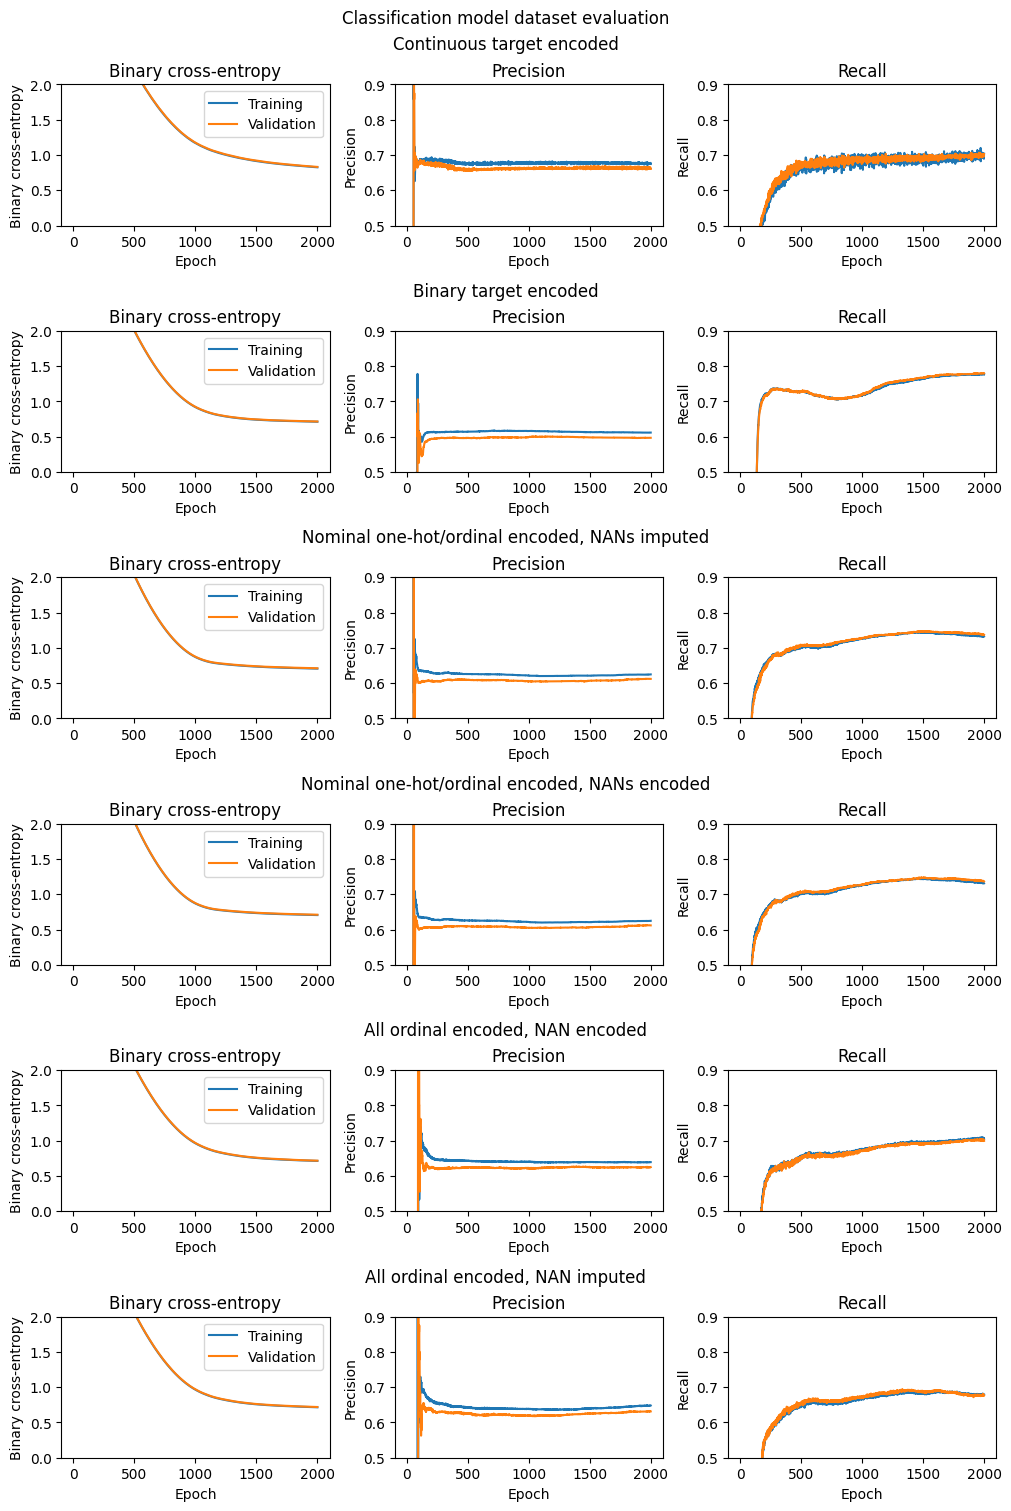

In [11]:
top_results=dataset_evaluation_scores_df['Dataset'].values
fig=plt.figure(figsize=(10,len(top_results)*2.5), constrained_layout=True)
fig.suptitle('Classification model dataset evaluation')

subfigs=fig.subfigures(nrows=len(top_results), ncols=1)

# Loop on the training results
for subfig, dataset in zip(subfigs, top_results):

    training_result=classification_training_results[dataset]
    # Row title
    subfig.suptitle(dataset)

    axs=subfig.subplots(nrows=1, ncols=3)

    axs[0].set_title('Binary cross-entropy')
    axs[0].plot(training_result.history['loss'], label='Training')
    axs[0].plot(training_result.history['val_loss'], label='Validation')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Binary cross-entropy')
    axs[0].set_ylim(0,2)
    axs[0].legend(loc='upper right')

    axs[1].set_title('Precision')
    axs[1].plot(training_result.history['precision'])
    axs[1].plot(training_result.history['val_precision'])
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Precision')
    axs[1].set_ylim(0.5,0.9)

    axs[2].set_title('Recall')
    axs[2].plot(training_result.history['recall'])
    axs[2].plot(training_result.history['val_recall'])
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Recall')
    axs[2].set_ylim(0.5,0.9)

# Save and show the plot
fig.savefig(classification_dataset_evaluation_training_curves_file, dpi=300, bbox_inches='tight')
fig.show()

In [12]:
data_file=datasets['Continuous target encoded']

# Load the data
with open(data_file, 'rb') as input_file:
    data_dict=pickle.load(input_file)

training_labels_df=data_dict['Training labels']
training_features_df=data_dict['Training features']

# Set the weight initializer function
initializer=GlorotUniform(seed=315)

# Set-up the L1L2 for the dense layers
regularizer=L1L2(l1=0.001, l2=0.0001)

model_layers=[Input(shape=training_features_df.shape[1])]
units=input_units

while units < max_units:
    model_layers.append(
        Dense(units, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer)
    )

    units*=2

for _ in range(waist_layers - 1):
    model_layers.append(
        Dense(max_units, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer)
    )

while units >= output_units:
    model_layers.append(
        Dense(units, kernel_regularizer=regularizer, activation='relu', kernel_initializer=initializer)
    )

    units/=step_down

model_layers.append(
    Dense(1, activation='sigmoid', kernel_initializer=initializer)
)

classification_model=Sequential(model_layers)

classification_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=[Precision(name='precision'), Recall(name='recall')]
)

# Calculate class weighting
pos_examples=sum(training_labels_df['efs'])
neg_examples=len(training_labels_df['efs']) - pos_examples
neg_class_weight=(1 / neg_examples) * (len(training_labels_df['efs']) / 2.0)
pos_class_weight=(1 / pos_examples) * (len(training_labels_df['efs']) / 2.0)

# Do the training run
training_results=classification_model.fit(
    training_features_df,
    training_labels_df['efs'],
    batch_size=1028,
    validation_split=0.25,
    epochs=training_epochs,
    verbose=False,
    class_weight={0: neg_class_weight, 1: pos_class_weight}
)

  1/270 [..............................] - ETA: 6s

270/270 [==============================] - 1s 3ms/step


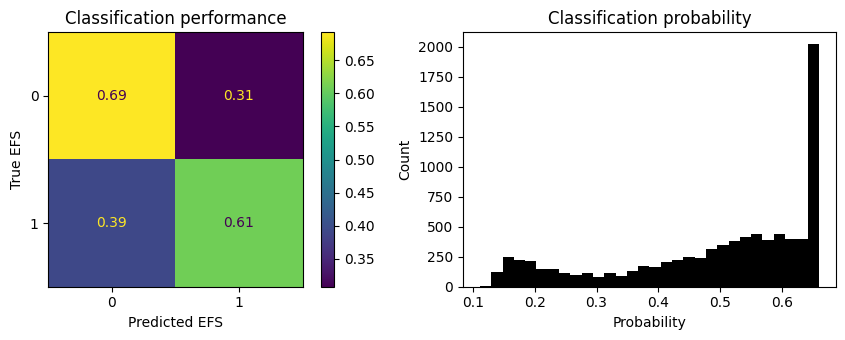

In [18]:
predictions=classification_model.predict(data_dict['Testing features'])

fig, axs=plt.subplots(1,2, figsize=(9,3.5))
axs=axs.flatten()

# Make calls with threshold
calls=np.where(predictions < 0.55, 0, 1)

# Plot the confusion matrix
cm=confusion_matrix(data_dict['Testing labels']['efs'], calls, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
_=cm_disp.plot(ax=axs[0])

axs[0].set_title('Classification performance')
axs[0].set_xlabel('Predicted EFS')
axs[0].set_ylabel('True EFS')

axs[1].set_title('Classification probability')
axs[1].hist(predictions, bins=30, color='black')
axs[1].set_xlabel('Probability')
axs[1].set_ylabel('Count')

fig.tight_layout()
fig.show()